# HSIC Measures

In [1]:
import sys
sys.path.append("../../")

import jax
import jax.numpy as np
import numpy as onp
import pandas as pd
from jax.config import config
config.update("jax_enable_x64", False)


# dependence measures
from jaxkern.similarity.hsic import HSIC, CKA, HSICRBF, CKARBF, HSICRBFSampler, CKARBFSampler
from jaxkern.kernels.linear import linear_kernel
from jaxkern.kernels.stationary import rbf_kernel
from jaxkern.kernels.utils import kernel_matrix
from jaxkern.kernels.sigma import estimate_sigma_median
from jaxkern.kernels.approx import RBFSampler
from jaxkern.kernels.sigma import estimate_sigma_median

from sklearn.preprocessing import StandardScaler

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Toy Data

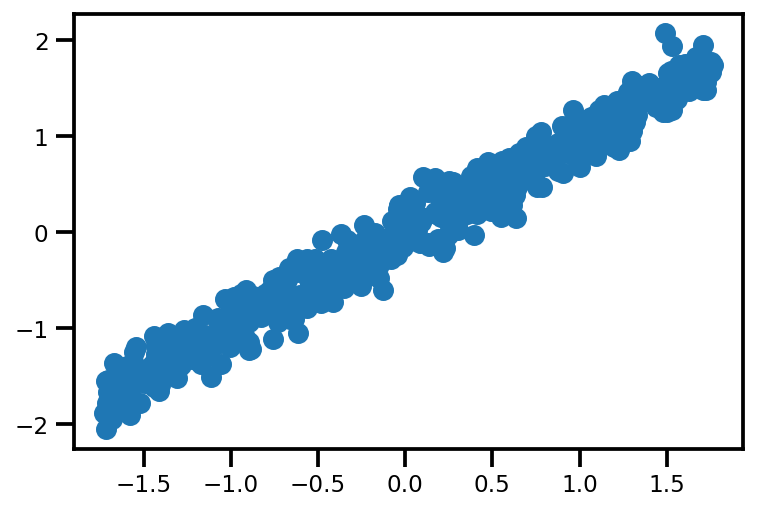

In [2]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 500
n_features = 1
noise_y = 0.5

X = rng.rand(n_samples, n_features)
Y = 10 * X + noise_y * rng.randn(n_samples, n_features)

X = StandardScaler().fit_transform(X)
Y = StandardScaler().fit_transform(Y)

X = np.array(X)
Y = np.array(Y)

plt.scatter(X, Y)

## Similarity Measures

## Similarity - Kernel-Based

In [3]:
# initialize kernel
lin_kern = jax.partial(kernel_matrix, linear_kernel)


#### HSIC

In [4]:
import objax

# initialize HSIC
hsic_clf = HSIC(lin_kern, lin_kern)

hsic_val = hsic_clf(X, Y)

print(f"HSIC: {hsic_val:.4f}")

HSIC: 0.9699


#### Normalized Variant (CKA)

HSIC can be difficult to interpret because it's not and it's not consistent (i.e. there is no approximate monotonic function that can describe HSIC as it grows). The HSIC metric is somewhat similar to the covariance matrix, we need to normalize by the sizes of the individual matrices.

In [5]:
# initialize HSIC
cka_clf = CKA(lin_kern, lin_kern)

cka_val = cka_clf(X, Y)

print(f"CKA: {cka_val:.4f}")

CKA: 0.9700


### HSIC, RBF Kernel

In [6]:
%%time
from jaxkern.kernels.stationary import RBF

# estimate the length scale
length_scale_X = estimate_sigma_median(X[:1000], X[:1000])
length_scale_Y = estimate_sigma_median(Y[:1000], Y[:1000])

print(length_scale_X, length_scale_Y)

# create the kernel matrix
rbf_kern_X = jax.partial(kernel_matrix, jax.partial(rbf_kernel, length_scale_X, 1.0))
rbf_kern_Y = jax.partial(kernel_matrix, jax.partial(rbf_kernel, length_scale_Y, 1.0))


hsic_rbf_clf = HSIC(
    kernel_X=rbf_kern_X, 
    kernel_Y=rbf_kern_Y,
)

hsic_val = hsic_rbf_clf(X, Y)

print(f"HSIC (rbf): {hsic_val:.4f}")

0.72456807 0.719218
HSIC (rbf): 0.1130
CPU times: user 853 ms, sys: 24.3 ms, total: 877 ms
Wall time: 845 ms


In [7]:
%%time
cka_rbf_clf = CKA(
    kernel_X=rbf_kern_X, 
    kernel_Y=rbf_kern_Y,
)

cka_val = cka_rbf_clf(X, Y)

print(f"CKA (rbf): {cka_val:.4f}")

CKA (rbf): 0.9383
CPU times: user 46.3 ms, sys: 14.2 ms, total: 60.4 ms
Wall time: 28.6 ms


### Convenience Function (RBF)

Everyone tends to use the RBF kernel because it is the easiest to use. Especially in unsupervised scenarios where we cannot actually learn the kernel parameters.

In [8]:
%%time

hsic_rbf_clf = HSICRBF(
    sigma_x=estimate_sigma_median, 
    sigma_y=estimate_sigma_median,
)

hsic_val = hsic_rbf_clf(X, Y)

print(f"HSIC (rbf): {hsic_val:.4f}")

HSIC (rbf): 0.1136
CPU times: user 316 ms, sys: 32 ms, total: 348 ms
Wall time: 307 ms


In [9]:
%%time

nhsic_rbf_clf = CKARBF(
    sigma_x=estimate_sigma_median, 
    sigma_y=estimate_sigma_median,
    bias=True
)

nhsic_val = nhsic_rbf_clf(X, Y)
print(nhsic_rbf_clf.sigma_x_, nhsic_rbf_clf.sigma_y_)
print(f"nHSIC (rbf): {nhsic_val:.4f}")

0.72456807 0.719218
nHSIC (rbf): 0.9383
CPU times: user 364 ms, sys: 28.9 ms, total: 393 ms
Wall time: 329 ms


In [10]:
from jaxkern.kernels.sigma import estimate_sigma_median_kth

In [18]:
for ik in [0.15, 0.3, 0.5, 0.7, 0.85]:

    est_k = jax.partial(estimate_sigma_median_kth, percent=ik)
    nhsic_rbf_clf = CKARBF(
        sigma_x=est_k, 
        sigma_y=est_k,
        bias=False
    )

    nhsic_val = nhsic_rbf_clf(X, Y)
    print(nhsic_rbf_clf.sigma_x_, nhsic_rbf_clf.sigma_y_)
    print(f"nHSIC (rbf, kth={ik}): {nhsic_val:.4f}")

0.075444035 0.07336891
nHSIC (rbf, kth=0.15): 0.3772
0.2959211 0.28885612
nHSIC (rbf, kth=0.3): 0.8110
0.8324282 0.8229587
nHSIC (rbf, kth=0.5): 0.9469
2.2329373 2.129347
nHSIC (rbf, kth=0.7): 0.9713
4.125067 4.072429
nHSIC (rbf, kth=0.85): 0.9921


## HSIC, RBF Sampler

In [12]:
n_samples = 100_000

X_s = rng.rand(n_samples, 1)
Y_s = X_s + 0.05 * rng.randn(n_samples, 1)

X_s = np.array(X_s)
Y_s = np.array(Y_s)

In [13]:
%%time


n_rff = 500

hsic_rff_clf = HSICRBFSampler(
    length_scale_X=estimate_sigma_median, 
    length_scale_Y=estimate_sigma_median,
    n_rff=n_rff
)



hsic_val = hsic_rff_clf(X_s, Y_s)

print(f"HSIC (rff): {hsic_val:.4f}")

HSIC (rff): 0.0666
CPU times: user 9.67 s, sys: 758 ms, total: 10.4 s
Wall time: 3.19 s


In [14]:
%%time


cka_rff_clf = CKARBFSampler(
    length_scale_X=estimate_sigma_median, 
    length_scale_Y=estimate_sigma_median,
    n_rff=n_rff
)
cka_val = cka_rff_clf(X_s, Y_s)

print(f"CKA (rff): {cka_val:.4f}")

CKA (rff): 0.7491
CPU times: user 15.2 s, sys: 1.59 s, total: 16.8 s
Wall time: 2.04 s


In [17]:
for ik in [0.15, 0.3, 0.5, 0.7, 0.85]:

    est_k = jax.partial(estimate_sigma_median_kth, percent=ik)
    nhsic_rbf_clf = CKARBFSampler(
        length_scale_X=est_k, 
        length_scale_Y=est_k,
        n_rff=n_rff
    )

    nhsic_val = nhsic_rbf_clf(X_s, Y_s)
    print(f"nHSIC (rff, kth={ik}): {nhsic_val:.4f}")

nHSIC (rbf, kth=0.15): 0.0778
nHSIC (rbf, kth=0.3): 0.4149
nHSIC (rbf, kth=0.5): 0.7911
nHSIC (rbf, kth=0.7): 0.9492
nHSIC (rbf, kth=0.85): 0.9685
